# 20.2 Continuous Treatment Extension

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Implementation](#implementation)
4. [Numeric Demonstration](#numeric)
5. [Interview Appendix](#interview)
6. [References](#references)

---

## Learning Objectives

By the end of this notebook, you will:
- Understand CATE as partial derivative for continuous treatments
- Derive the continuous treatment target transformation
- Implement price elasticity estimation with ML models
- Recognize when ordering effects is sufficient vs. needing exact magnitudes

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Intuition <a name="intuition"></a>

### From Binary to Continuous Treatment

**Binary treatment**: CATE = effect of switching from T=0 to T=1
$$\tau(x) = E[Y(1) - Y(0) | X]$$

**Continuous treatment**: CATE = marginal effect of increasing T
$$\tau(x) = E\left[\frac{\partial Y(t)}{\partial t} \Big| X\right]$$

### Price Elasticity Example

Consider ice cream sales:
- **Treatment**: Price (continuous)
- **Outcome**: Sales quantity
- **CATE**: How much do sales change per unit price increase?

This varies by context:
- **Hot days**: People less price-sensitive (lower |elasticity|)
- **Cold days**: People more price-sensitive (higher |elasticity|)

### Local Linear Model Intuition

Assume locally linear relationship:
$$Y_i = \alpha + \beta T_i + e_i \quad | X_i = x$$

The CATE $\tau(x) = \beta$ is the slope in this local model.

**OLS estimator** for $\beta$:
$$\hat{\beta} = \frac{Cov(Y, T)}{Var(T)} = \frac{\sum(Y_i - \bar{Y})(T_i - \bar{T})}{\sum(T_i - \bar{T})^2}$$

---

## 2. Formal Treatment <a name="formal"></a>

### Target Transformation for Continuous Treatment

**Full transformation** (scaled to equal CATE in expectation):
$$Y^*_i = (Y_i - \bar{Y}) \cdot \frac{T_i - \bar{T}}{\sigma^2_T}$$

**Simplified transformation** (for ordering only):
$$Y^*_i = (Y_i - \bar{Y})(T_i - \bar{T})$$

### Proof: $E[Y^* | X] = \tau(X)$

**Define**: $V_i = \frac{T_i - \bar{T}}{\sigma^2_T}$

**Key properties** (under random treatment assignment):
1. $E[V_i | X=x] = 0$ (centered treatment)
2. $E[T_i V_i | X=x] = 1$ (by definition of variance)
3. $E[e_i V_i | X=x] = 0$ (independence under RCT)

**Derivation**:
$$\begin{aligned}
E[Y^*_i | X=x] &= E[(Y_i - \bar{Y})V_i | X=x] \\
&= E[(\alpha + \beta T_i + e_i - \bar{Y})V_i | X=x] \\
&= \alpha \cdot E[V_i | X=x] + \beta \cdot E[T_i V_i | X=x] + E[e_i V_i | X=x] \\
&= \alpha \cdot 0 + \beta \cdot 1 + 0 \\
&= \beta = \tau(x)
\end{aligned}$$

### Non-Random Treatment

For observational data, replace $\bar{T}$ with conditional expectation $M(X_i) = E[T|X]$:

$$Y^*_i = (Y_i - \bar{Y}) \cdot \frac{T_i - M(X_i)}{(T_i - M(X_i))^2}$$

This ensures $E[V_i|X=x] = 0$ for proper identification.

---

## 3. Implementation <a name="implementation"></a>

In [2]:
def continuous_f_learner_transform(Y: np.ndarray, T: np.ndarray, 
                                    scale: bool = False) -> np.ndarray:
    """
    F-learner target transformation for continuous treatment.
    
    Parameters
    ----------
    Y : array-like
        Outcome variable
    T : array-like
        Continuous treatment variable
    scale : bool, default False
        If True, divide by treatment variance for exact CATE.
        If False, only useful for ordering (not magnitude).
        
    Returns
    -------
    Y_star : array
        Transformed target where E[Y*|X] ∝ CATE(X)
    """
    Y_centered = Y - Y.mean()
    T_centered = T - T.mean()
    
    if scale:
        T_var = T.var()
        return Y_centered * T_centered / T_var
    else:
        return Y_centered * T_centered


class ContinuousFLearner:
    """
    F-Learner for continuous treatment effects.
    
    Estimates marginal effect dY/dT for different covariate profiles.
    """
    
    def __init__(self, base_model=None, scale: bool = False):
        """
        Parameters
        ----------
        base_model : sklearn-compatible regressor, optional
            Default: LGBMRegressor with conservative hyperparameters
        scale : bool, default False
            Whether to scale by treatment variance for exact CATE
        """
        if base_model is None:
            base_model = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5, verbose=-1)
        self.model = base_model
        self.scale = scale
        self.T_mean_ = None
        self.Y_mean_ = None
        self.T_var_ = None
        
    def fit(self, X, Y, T):
        """
        Fit continuous F-learner.
        
        Parameters
        ----------
        X : array-like (n, p)
            Covariates (NOT including treatment)
        Y : array-like (n,)
            Outcome
        T : array-like (n,)
            Continuous treatment
        """
        self.T_mean_ = T.mean()
        self.Y_mean_ = Y.mean()
        self.T_var_ = T.var()
        
        Y_star = continuous_f_learner_transform(Y, T, scale=self.scale)
        self.model.fit(X, Y_star)
        return self
    
    def predict(self, X):
        """
        Predict CATE (or proportional to CATE if scale=False).
        """
        return self.model.predict(X)

print("Continuous F-Learner implementation ready")

Continuous F-Learner implementation ready


---

## 4. Numeric Demonstration <a name="numeric"></a>

### Ice Cream Pricing Experiment

Estimate price elasticity (how sales respond to price changes) for different contexts.

In [3]:
# Load ice cream sales (randomized prices)
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')
print(f"Dataset shape: {prices_rnd.shape}")
prices_rnd.head()

Dataset shape: (5000, 5)


,temp,weekday,cost,price,sales
0,25.8000,1,0.3000,7,230
1,22.7000,3,0.5000,4,190
2,33.7000,7,1.0000,5,237
3,23.0000,4,0.5000,5,193
4,24.4000,1,1.0000,3,252


In [4]:
# Define variables
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

# Train/test split
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
print(f"Train: {train.shape[0]}, Test: {test.shape[0]}")

# Overall elasticity (ATE)
overall_elast = np.cov(train[y], train[T])[0,1] / np.var(train[T])
print(f"Overall price elasticity: {overall_elast:.2f} sales per unit price")

Train: 3500, Test: 1500
Overall price elasticity: -2.59 sales per unit price


In [5]:
# Apply continuous target transformation (unscaled - for ordering)
Y_star_cont = continuous_f_learner_transform(
    train[y].values, 
    train[T].values, 
    scale=False
)

print("Target Transformation Statistics:")
print(f"  Original Y (sales) range: [{train[y].min()}, {train[y].max()}]")
print(f"  Transformed Y* range: [{Y_star_cont.min():.1f}, {Y_star_cont.max():.1f}]")
print(f"  Y* mean: {Y_star_cont.mean():.2f}")

Target Transformation Statistics:
  Original Y (sales) range: [149, 264]
  Transformed Y* range: [-217.8, 138.8]
  Y* mean: -13.77


In [6]:
# Fit continuous F-learner
cont_f_learner = ContinuousFLearner(scale=False)
cont_f_learner.fit(train[X], train[y].values, train[T].values)

# Predict elasticity ordering
test_pred = test.assign(cate=cont_f_learner.predict(test[X]))

print("CATE Predictions (proportional to elasticity):")
print(f"  Range: [{test_pred['cate'].min():.1f}, {test_pred['cate'].max():.1f}]")
print(f"  Note: More negative = more price-sensitive")

test_pred.sample(5)

CATE Predictions (proportional to elasticity):
  Range: [-61.7, 14.0]
  Note: More negative = more price-sensitive


,temp,weekday,cost,price,sales,cate
603,17.0000,7,0.3000,9,211,-42.8442
1040,21.5000,3,1.0000,5,193,-3.3204
3810,17.7000,7,0.3000,9,201,-42.8442
4829,21.4000,5,0.5000,9,188,-2.5569
1971,28.8000,4,0.3000,6,201,7.8472


In [7]:
# Define evaluation functions
def sensitivity(data, y, t):
    """Estimate treatment effect (elasticity) via OLS coefficient."""
    t_bar = data[t].mean()
    y_bar = data[y].mean()
    cov = np.sum((data[t] - t_bar) * (data[y] - y_bar))
    var = np.sum((data[t] - t_bar) ** 2)
    return cov / var if var > 0 else 0

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    """Compute cumulative gain curve."""
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) 
                     for rows in n_rows])

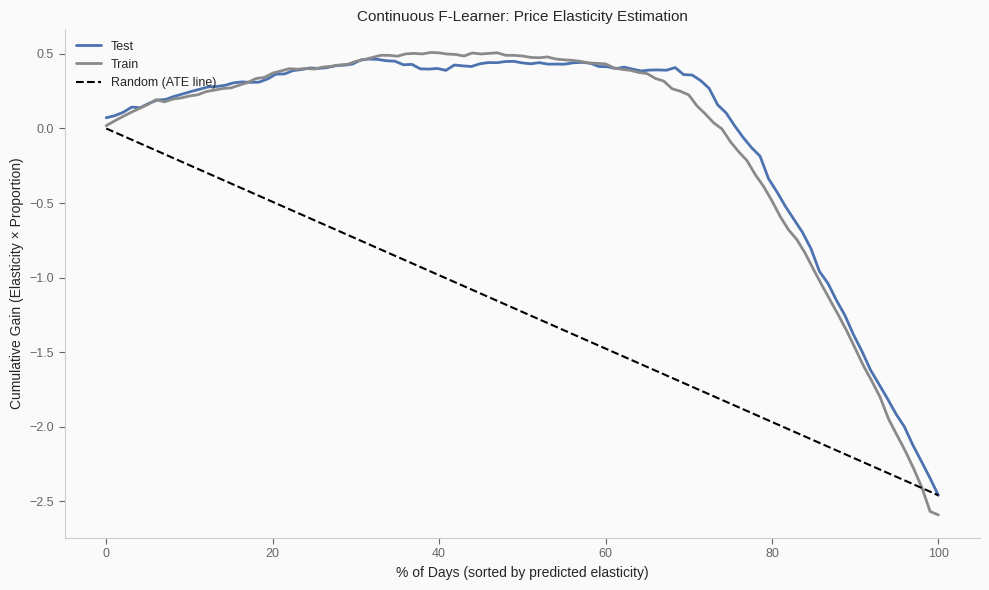


Baseline elasticity: -2.46


In [8]:
# Evaluate with cumulative gain curves
gain_curve_test = cumulative_gain(test_pred, "cate", y="sales", t="price")

train_pred = train.assign(cate=cont_f_learner.predict(train[X]))
gain_curve_train = cumulative_gain(train_pred, "cate", y="sales", t="price")

# Baseline elasticity
baseline_elast = sensitivity(test, "sales", "price")

# Plot
fig, ax = create_tufte_figure(figsize=(10, 6))

# Use separate x axes for each curve to handle different lengths
x_axis_test = np.linspace(0, 100, len(gain_curve_test))
x_axis_train = np.linspace(0, 100, len(gain_curve_train))

ax.plot(x_axis_test, gain_curve_test, color=COLORS['blue'], linewidth=2, label='Test')
ax.plot(x_axis_train, gain_curve_train, color=COLORS['gray'], linewidth=2, label='Train')
ax.plot([0, 100], [0, baseline_elast], linestyle='--', color='black', 
        linewidth=1.5, label='Random (ATE line)')

ax.set_xlabel('% of Days (sorted by predicted elasticity)')
ax.set_ylabel('Cumulative Gain (Elasticity × Proportion)')
ax.set_title('Continuous F-Learner: Price Elasticity Estimation')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nBaseline elasticity: {baseline_elast:.2f}")

### Key Observation

The continuous F-learner shows:
1. **Strong performance** - curve well above diagonal
2. **Low overfitting** - train and test curves are close
3. **Effective ordering** - successfully identifies high/low elasticity days

In [9]:
# Examine what drives elasticity heterogeneity
test_pred['elasticity_band'] = pd.qcut(test_pred['cate'], q=5, 
                                        labels=['Very Sensitive', 'Sensitive', 'Average', 
                                                'Insensitive', 'Very Insensitive'])

# Characteristics by band
band_chars = test_pred.groupby('elasticity_band', observed=True).agg({
    'temp': 'mean',
    'weekday': 'mean',
    'cost': 'mean',
    'sales': 'mean',
    'price': 'mean'
}).round(2)

# Actual elasticity by band
band_elast = test_pred.groupby('elasticity_band', observed=True).apply(
    lambda df: sensitivity(df, 'sales', 'price'),
    include_groups=False
).rename('actual_elasticity')

result = pd.concat([band_chars, band_elast], axis=1)
print("Characteristics by Predicted Elasticity Band:")
result

Characteristics by Predicted Elasticity Band:


,temp,weekday,cost,sales,price,actual_elasticity
elasticity_band,,,,,,
Very Sensitive,25.3200,4.5000,0.8600,221.3800,6.4400,-10.5104
Sensitive,19.3900,3.4200,0.7600,195.5800,6.5200,-3.5488
Average,22.8500,3.8000,0.6200,189.6800,6.5700,0.2832
Insensitive,25.6500,4.1800,0.7000,198.5200,6.3700,0.3488
Very Insensitive,26.0900,4.2100,1.1600,204.5100,6.5500,1.5551


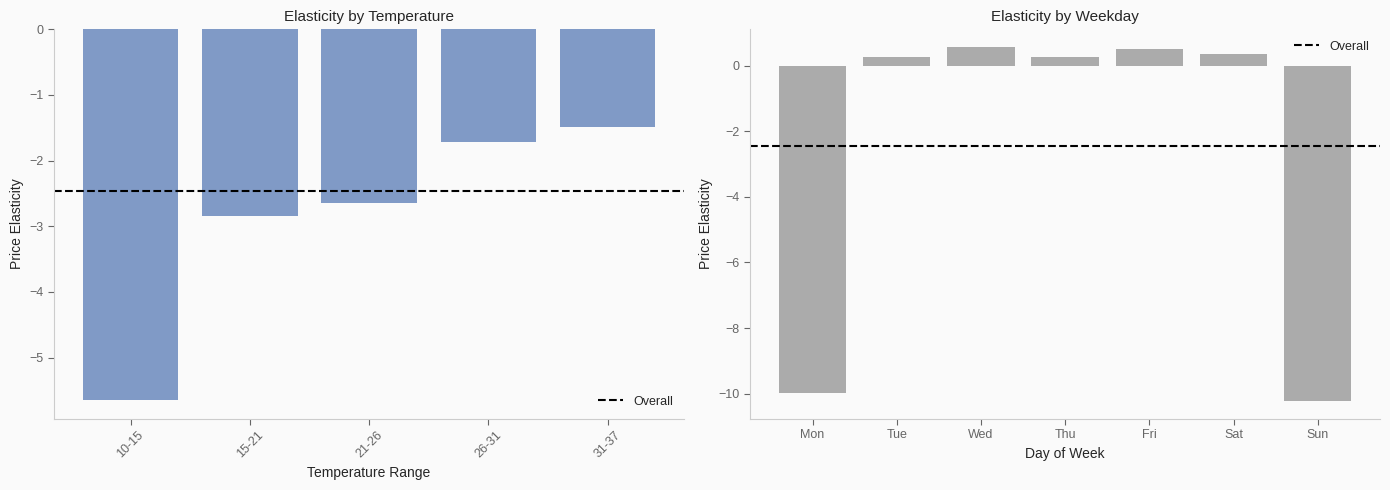


Insight: Warmer days → less price sensitive (elasticity closer to 0)
This makes sense: hot weather increases ice cream demand regardless of price.


In [10]:
# Visualize: Temperature vs Elasticity
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Temperature bins
test_pred['temp_bin'] = pd.cut(test_pred['temp'], bins=5)
temp_elast = test_pred.groupby('temp_bin', observed=True).apply(
    lambda df: sensitivity(df, 'sales', 'price'),
    include_groups=False
)

axes[0].bar(range(len(temp_elast)), temp_elast.values, color=COLORS['blue'], alpha=0.7)
axes[0].axhline(y=baseline_elast, color='black', linestyle='--', label='Overall')
axes[0].set_xticks(range(len(temp_elast)))
axes[0].set_xticklabels([f'{b.left:.0f}-{b.right:.0f}' for b in temp_elast.index], rotation=45)
axes[0].set_xlabel('Temperature Range')
axes[0].set_ylabel('Price Elasticity')
axes[0].set_title('Elasticity by Temperature')
axes[0].legend()

# Weekday effect
weekday_elast = test_pred.groupby('weekday').apply(
    lambda df: sensitivity(df, 'sales', 'price'),
    include_groups=False
)

axes[1].bar(range(len(weekday_elast)), weekday_elast.values, color=COLORS['gray'], alpha=0.7)
axes[1].axhline(y=baseline_elast, color='black', linestyle='--', label='Overall')
axes[1].set_xticks(range(len(weekday_elast)))
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Price Elasticity')
axes[1].set_title('Elasticity by Weekday')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nInsight: Warmer days → less price sensitive (elasticity closer to 0)")
print("This makes sense: hot weather increases ice cream demand regardless of price.")

### Business Implication

**Pricing Strategy**:
- **Hot days**: Customers less price-sensitive → can charge higher prices
- **Cold days**: Customers more price-sensitive → need competitive pricing

The continuous F-learner successfully identifies this heterogeneity, enabling dynamic pricing.

---

## 5. Interview Appendix <a name="interview"></a>

### Q1: How does CATE differ between binary and continuous treatments?

<details>
<summary>Solution</summary>

**Binary treatment**:
$$\tau(x) = E[Y(1) - Y(0) | X = x]$$
Interpretation: Effect of switching from untreated to treated.

**Continuous treatment**:
$$\tau(x) = E\left[\frac{\partial Y(t)}{\partial t} \Big| X = x\right]$$
Interpretation: Marginal effect of increasing treatment by one unit.

Key differences:
- Binary: "On vs Off" comparison
- Continuous: Slope/derivative interpretation
- Continuous assumes local linearity

</details>

### Q2: Why might you use the unscaled transformation?

<details>
<summary>Solution</summary>

**Full transformation** (scaled):
$$Y^* = (Y - \bar{Y}) \cdot \frac{T - \bar{T}}{\sigma^2_T}$$

**Simplified** (unscaled):
$$Y^* = (Y - \bar{Y})(T - \bar{T})$$

Use unscaled when:
1. **Only ordering matters**: Rank units by effect magnitude without needing exact values
2. **Targeting decisions**: "Who responds most?" not "By how much?"
3. **Avoid division issues**: $\sigma^2_T$ can be unstable in small samples

The unscaled version preserves ordering ($Y^*_{scaled} = Y^*_{unscaled} / \sigma^2_T$) since division by constant doesn't change rank.

</details>

### Q3: What assumption is required for the continuous F-learner?

<details>
<summary>Solution</summary>

**Local linearity assumption**:
$$Y_i = \alpha + \beta T_i + e_i \quad | X_i = x$$

Within each covariate region $X=x$, the outcome is linear in treatment.

**Why needed**:
- The transformation estimates the *slope* $\beta$
- If relationship is nonlinear, slope varies with treatment level
- Model conflates treatment-level heterogeneity with covariate heterogeneity

**When violated**:
- Diminishing returns (concave)
- Saturation effects
- U-shaped or non-monotonic relationships

**Mitigation**: Linearization via transformations (log-log for elasticity, etc.)

</details>

---

## 6. References <a name="references"></a>

1. **Facure, M.** (2022). *Causal Inference for the Brave and True*, Chapter 20.

2. **Kennedy, E.H.** (2020). *Optimal doubly robust estimation of heterogeneous causal effects*. arXiv:2004.14497.

3. **Nie, X. & Wager, S.** (2021). *Quasi-oracle estimation of heterogeneous treatment effects*. Biometrika.